## Import Libraries

In [664]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [665]:
pd.set_option('display.max_rows', 50)

## Import Datasets

In [666]:
train_data = pd.read_csv("Kaggle_Dataset/PM_train.txt", sep=" ", header=None)
test_data = pd.read_csv("Kaggle_Dataset/PM_test.txt", sep=" ", header=None)
ground_truth = pd.read_csv("Kaggle_Dataset/PM_truth.txt", sep=" ", header=None)

### Drop Empty Columns

In [667]:
train_data.dropna(axis=1, inplace=True)
test_data.dropna(axis=1, inplace=True)
ground_truth.dropna(axis=1, inplace=True)

### Label Columns

In [668]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_data.columns = cols_names
test_data.columns = cols_names
ground_truth.columns = ['ttf']

### Sort columns by the attributes 'id' and 'cycle'

In [669]:
train_data = train_data.sort_values(['id', 'cycle'])
test_data = test_data.sort_values(['id', 'cycle'])

### Normalize training data in all columns that are different to 'id' and 'cycle' using Zscore

In [670]:
norm_cols = train_data.columns.difference(['id', 'cycle'])

min_max_scaler = preprocessing.MinMaxScaler()

norm_train_data = pd.DataFrame(min_max_scaler.fit_transform(train_data[norm_cols]), 
                               columns=norm_cols, index=train_data.index)

join_train_data = train_data[["id", "cycle"]].join(norm_train_data)

train_data = join_train_data.reindex(columns = train_data.columns)

norm_cols = test_data.columns.difference(['id', 'cycle'])

min_max_scaler = preprocessing.MinMaxScaler()

norm_test_data = pd.DataFrame(min_max_scaler.fit_transform(test_data[norm_cols]), 
                               columns=norm_cols, index=test_data.index)

join_test_data = test_data[["id", "cycle"]].join(norm_test_data)

test_data = join_test_data.reindex(columns = test_data.columns)

In [671]:
def create_rul_column(data):
    rul = pd.DataFrame(data.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    data = data.merge(rul, on=['id'], how='left')
    data['RUL'] = data['max'] - data['cycle']
    data.drop('max', axis=1, inplace=True)
    return data

train_data = create_rul_column(train_data)
test_data = create_rul_column(test_data)

## Feature Engineering

In [672]:
def add_features(df, rolling_win_size):
    sensor_cols = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
    sensor_av_cols = [s + '_av' for s in sensor_cols]
    sensor_sd_cols = [s + '_sd' for s in sensor_cols]
    
    df_out = pd.DataFrame()
    ws = rolling_win_size

    for m_id in pd.unique(df.id):
    
        # get a subset for each engine sensors
        df_engine = df[df['id'] == m_id]
        df_sub = df_engine[sensor_cols]

    
        # get rolling mean for the subset
        av = df_sub.rolling(ws, min_periods=1).mean()
        av.columns = sensor_av_cols
    
        # get the rolling standard deviation for the subset
        sd = df_sub.rolling(ws, min_periods=1).std().fillna(0)
        sd.columns = sensor_sd_cols
    
        # combine the subset with the rolling mean and standard deviation
        new_ftrs = pd.concat([df_engine, av, sd], axis=1)

        # add the new features to the output data frame
        df_out = pd.concat([df_out, new_ftrs])

    return df_out

def prepare_train_data(df, period):
    df_max_cycle = pd.DataFrame(df.groupby('id')['cycle'].max())
    df_max_cycle.reset_index(level=0, inplace=True)
    df_max_cycle.columns = ['id', 'last_cycle']
    df = pd.merge(df, df_max_cycle, on='id')
    df['ttf'] = df['last_cycle'] - df['cycle']
    df.drop(['last_cycle'], axis=1, inplace=True)

    #create binary classification label
    df['label_bc'] = df['ttf'].apply(lambda x: 1 if x <= period else 0)

    return df

In [673]:
def prepare_test_data(df_test_in, df_truth_in, period):
    
    df_tst_last_cycle = pd.DataFrame(df_test_in.groupby('id')['cycle'].max())
    
    df_tst_last_cycle.reset_index(level=0, inplace=True)
    df_tst_last_cycle.columns = ['id', 'last_cycle']
#     , inplace=True
    df_test_in = pd.merge(df_test_in, df_tst_last_cycle, on='id')


    df_test_in = df_test_in[df_test_in['cycle'] == df_test_in['last_cycle']]

    df_test_in.drop(['last_cycle'], axis=1, inplace=True)
    
    df_test_in.reset_index(drop=True, inplace=True)
    
    df_test_in = pd.concat([df_test_in, df_truth_in], axis=1)
    
    #create binary classification label
    df_test_in['label_bnc'] = df_test_in['ttf'].apply(lambda x: 1 if x <= period else 0)
    
    return df_test_in

In [674]:
df_train_extracted_features = add_features(train_data, 5)
train_data = prepare_train_data(df_train_extracted_features, 30)

test_data_extracted_features = add_features(test_data, 5)
test_data = prepare_test_data(test_data_extracted_features, ground_truth, 30)

## EDA

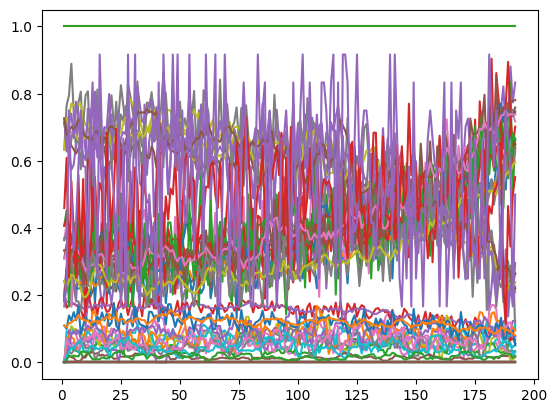

In [675]:
# Plot dynamic sensor data
for i in train_data.columns.difference(['id', 'cycle', 'RUL', 'label_bc', 'ttf']):
   plt.plot(train_data[train_data["id"] == 1]["cycle"], train_data[i][train_data["id"] == 1], label=i)
    #print(i)
plt.show()

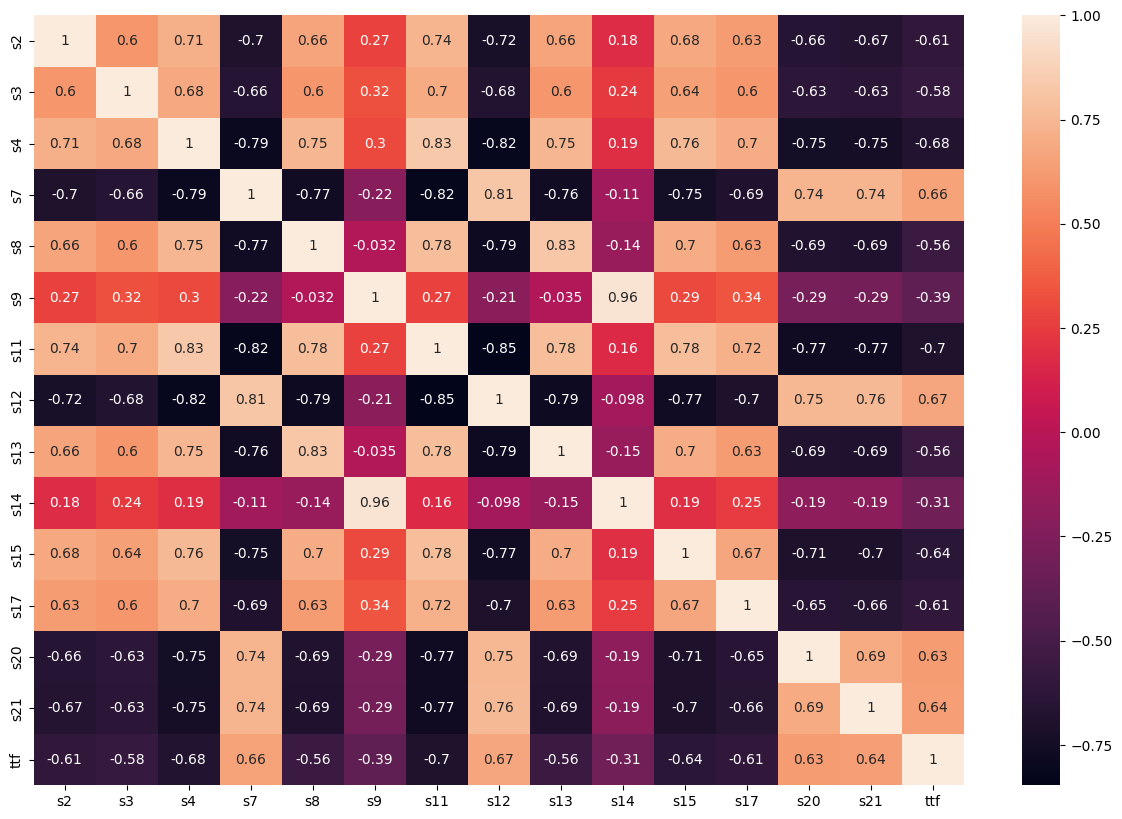

In [676]:
features_orig = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
features_av_sd = ['s1_av', 's2_av', 's3_av', 's4_av', 's7_av', 's8_av', 's9_av', 's11_av', 's12_av', 's13_av', 's14_av', 's15_av', 's17_av', 's20_av', 's21_av', 's1_sd', 's2_sd', 's3_sd', 's4_sd', 's7_sd', 's8_sd', 's9_sd', 's11_sd', 's12_sd', 's13_sd', 's14_sd', 's15_sd', 's17_sd', 's20_sd', 's21_sd']
features_low_corr = ['setting3', 's1', 's6', 's10', 's18','s19','s16','s5', 'setting1', 'setting2']
features_high_corr = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21']
features = features_high_corr
plt.figure(figsize=(15,10))	
corr = train_data[features + ['ttf']].corr()
sns.heatmap(corr, annot=True)


X_train = train_data[features]
y_train = train_data['ttf']
X_test = test_data[features]
y_test = test_data['ttf']
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model training

In [737]:
# Training the model	
# best params n_estimators=55, max_depth=2, max_features=2: r2=0.668, RMSE = 23.955, MAE = 18.866
model = RandomForestRegressor(n_estimators=55, max_depth=2, random_state=42, max_features=2, n_jobs=-1, verbose=1)

history = model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.0s finished


In [738]:
# Evaluate the model
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Train vs Test: " , r2_score(y_train, y_train_pred), r2_score(y_test, y_pred))

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R2: ", r2)

Train vs Test:  0.5333741227121656 0.6676874591473223
RMSE:  23.955384039861418
MAE:  18.86588685323968
R2:  0.6676874591473223


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  55 out of  55 | elapsed:    0.0s finished
